In [ ]:
import numpy as np
import tensorflow as tf
import os
from os.path import isfile, join
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/UAH-DRIVESET-v1'

In [ ]:
def get_dataset(data_path, shape, train_per = 0.7, val_per = 0.1, test_per = 0.2):
    # initialize data variable as list
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path, topdown=False):
        if len(files) < 2:
            continue
        else:
            gps_df = get_data_list(root, shape)
            
            train_split_index = int(train_per * len(gps_df))
            val_split_index = int(val_per * len(gps_df)) + train_split_index

            X_train.extend(gps_df[: train_split_index])
            for i in range(train_split_index):
              Y_train.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

            X_val.extend(gps_df[train_split_index:val_split_index])
            for i in range(train_split_index, val_split_index):
              Y_val.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

            X_test.extend(gps_df[val_split_index:])
            for i in range(val_split_index, len(gps_df)):
              Y_test.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

    labels_columns = ["driver", "type", "road"]
    Y_train = pd.DataFrame(data= np.array(Y_train), columns=labels_columns)
    Y_val = pd.DataFrame(data= np.array(Y_val), columns=labels_columns)
    Y_test = pd.DataFrame(data= np.array(Y_test), columns=labels_columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test


def get_data_list(root, shape):
    data_list = []
    gps_df = import_uah_trip_data(root)
    divisions = int(len(gps_df)/shape)
    gps_df = gps_df[:divisions * shape]
    for i in range(divisions):
      data_list.append(gps_df[shape * (i):shape * (i+1)])
    return data_list

def import_uah_trip_data(root_path):
    # import raw inertial data
    gps_file_path = os.path.join(root_path, "RAW_GPS.txt")
    gps_df = pd.read_csv(gps_file_path, sep=" ", header=None).iloc[:, 0:7]
    # add the column names
    gps_df.columns = [
        "timestamp",
        "speed",
        "latitude",
        "longitude",
        "altitude",
        "verticalAccuracy",
        "horizentalAccuracy",
    ]
    dataFrame = pd.DataFrame(data=gps_df, columns=gps_df.columns)
    return dataFrame

def get_trip_labels(file_path):
    if "NORMAL" in file_path:
        label = "NORMAL"
    elif "AGGRESSIVE" in file_path:
        label = "AGGRESSIVE"
    elif "DROWSY" in file_path:
        label = "DROWSY"
    else:
        label = None
    return label


def get_road_type(file_path):
    if "SECONDARY" in file_path:
        return "secondary"
    elif "MOTORWAY" in file_path:
        return "motorway"
    else:
        return None

In [ ]:
def normalization(X_train, X_val, X_test, type = 'standardization'):
    if type == 'min-max':
        for i in range(len(X_train[0,0])):
            train_min, train_max = X_train[:,0,i].min(),X_train[:,0,i].max() 
            X_train[:,0,i] = (X_train[:,0,i] - train_min)/(train_max - train_min)
            X_val[:,0,i] = (X_val[:,0,i] - train_min)/(train_max - train_min)
            X_test[:,0,i] = (X_test[:,0,i] - train_min)/(train_max - train_min)
    elif type == 'standardization':
        for i in range(len(X_train[0,0])):
            train_mean, train_std = X_train[:,0,i].mean(),X_train[:,0,i].std() 
            X_train[:,0,i] = (X_train[:,0,i] - train_mean)/train_std
            X_val[:,0,i] = (X_val[:,0,i] - train_mean)/train_std
            X_test[:,0,i] = (X_test[:,0,i] - train_mean)/train_std
    return X_train, X_val, X_test

In [ ]:
def oneHotEndcoding(Y_train, Y_val, Y_test):
    Y_train_oh = pd.get_dummies(Y_train.type, prefix='type')
    Y_val_oh = pd.get_dummies(Y_val.type, prefix='type')
    Y_test_oh = pd.get_dummies(Y_test.type, prefix='type')
    return Y_train_oh, Y_val_oh, Y_test_oh

In [ ]:
# def my_model_fully_connected(ishape, k = 2, lr = 1e-4, drop_out = 0.1, weight_decay = 1e-3):
#     model_input = tf.keras.layers.Input(shape=ishape)
#     model_input_flatten = tf.keras.layers.Flatten()(model_input)
#     l1 = tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(model_input_flatten)
#     l1_Batch = tf.keras.layers.BatchNormalization()(l1)
#     l1_dropOut = tf.keras.layers.Dropout(drop_out)(l1_Batch)

#     l2 = tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l1_dropOut)
#     l2_Batch = tf.keras.layers.BatchNormalization()(l2)
#     l2_dropOut = tf.keras.layers.Dropout(2*drop_out)(l2_Batch)

#     l3 = tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l2_dropOut)
#     l3_Batch = tf.keras.layers.BatchNormalization()(l3)
#     l3_dropOut = tf.keras.layers.Dropout(3*drop_out)(l3_Batch)

#     # l4 = tf.keras.layers.Dense(8*16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l3_dropOut)
#     # l4_Batch = tf.keras.layers.BatchNormalization()(l4)
#     # l4_dropOut = tf.keras.layers.Dropout(3*drop_out)(l4_Batch)

#     # l5 = tf.keras.layers.Dense(8*8, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l4_dropOut)
#     # l5_Batch = tf.keras.layers.BatchNormalization()(l5)
#     # l5_dropOut = tf.keras.layers.Dropout(5*drop_out)(l5_Batch)

#     l6 = tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l3_dropOut)
#     l6_Batch = tf.keras.layers.BatchNormalization()(l6)
#     l6_dropOut = tf.keras.layers.Dropout(5*drop_out)(l6_Batch)

#     out = tf.keras.layers.Dense(k,activation = 'softmax')(l6_dropOut)
#     model = tf.keras.models.Model(inputs = model_input, outputs = out)
#     # opt_rms = tf.keras.optimizers.RMSprop(lr=lr,decay=1e-6)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    
#     return model

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [ ]:
def my_model_fully_connected(ishape, k = 3, lr = 1e-4, drop_out = 0.1, weight_decay = 1e-4):
    model_input = tf.keras.layers.Input(shape=ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    l1 = tf.keras.layers.Dense(512, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(model_input_flatten)
    l1_Batch = tf.keras.layers.BatchNormalization()(l1)
    # l1_dropOut = tf.keras.layers.Dropout(drop_out)(l1_Batch)

    l2 = tf.keras.layers.Dense(512, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l1_Batch)
    l2_Batch = tf.keras.layers.BatchNormalization()(l2)
    # l2_dropOut = tf.keras.layers.Dropout(2*drop_out)(l2_Batch)

    l3 = tf.keras.layers.Dense(256, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l2_Batch)
    l3_Batch = tf.keras.layers.BatchNormalization()(l3)
    # l3_dropOut = tf.keras.layers.Dropout(3*drop_out)(l3_Batch)

    l4 = tf.keras.layers.Dense(256, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l3_Batch)
    l4_Batch = tf.keras.layers.BatchNormalization()(l4)
    # l4_dropOut = tf.keras.layers.Dropout(4*drop_out)(l4_Batch)

    l5 = tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l4_Batch)
    l5_Batch = tf.keras.layers.BatchNormalization()(l5)
    # l5_dropOut = tf.keras.layers.Dropout(5*drop_out)(l5_Batch)

    l6 = tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l5_Batch)
    l6_Batch = tf.keras.layers.BatchNormalization()(l6)
    # l6_dropOut = tf.keras.layers.Dropout(5*drop_out)(l6_Batch)

    l7 = tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l6_Batch)
    l7_Batch = tf.keras.layers.BatchNormalization()(l7)
    # l7_dropOut = tf.keras.layers.Dropout(3*drop_out)(l7_Batch)

    l8 = tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l7_Batch)
    l8_Batch = tf.keras.layers.BatchNormalization()(l8)
    # l8_dropOut = tf.keras.layers.Dropout(5*drop_out)(l8_Batch)

    l9 = tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l8_Batch)
    l9_Batch = tf.keras.layers.BatchNormalization()(l9)
    # l9_dropOut = tf.keras.layers.Dropout(5*drop_out)(l9_Batch)

    l10 = tf.keras.layers.Dense(16, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(weight_decay))(l9_Batch)
    l10_Batch = tf.keras.layers.BatchNormalization()(l10)
    
    out = tf.keras.layers.Dense(k,activation = 'softmax')(l10_Batch)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    opt_rms = tf.keras.optimizers.RMSprop(lr=lr,decay=1e-6)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy", f1])
    return model

In [ ]:
model_name_fcn = "team_4_FCN.h5"
def callbacks():
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40)

    monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                                verbose=0,save_best_only=True,\
                                                save_weights_only=True,\
                                                mode='min')
    # Learning rate schedule
    def scheduler(epoch, lr):
        if epoch%60 == 0:
            lr = lr/2
        return lr

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
    
    return early_stop, monitor, lr_schedule

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape=shape)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21659, 1, 7)
(6231, 1, 7)
(3079, 1, 7)


In [ ]:
model_FC = my_model_fully_connected(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks()
print(model_FC.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               4096      
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               1313

In [ ]:
history_FC = model_FC.fit(X_train, Y_train_oh, batch_size = 32, epochs = 200, verbose = 1, callbacks=[early_stop, monitor, lr_schedule], validation_data = (X_val, Y_val_oh))

Epoch 1/200
677/677 [==============================] - 13s 14ms/step - loss: 1.1182 - accuracy: 0.5354 - f1: 0.4694 - val_loss: 0.9656 - val_accuracy: 0.5947 - val_f1: 0.4818
Epoch 2/200
677/677 [==============================] - 10s 14ms/step - loss: 0.9870 - accuracy: 0.6083 - f1: 0.5592 - val_loss: 0.9501 - val_accuracy: 0.5895 - val_f1: 0.4959
Epoch 3/200
677/677 [==============================] - 9s 14ms/step - loss: 0.9580 - accuracy: 0.6219 - f1: 0.5776 - val_loss: 0.9737 - val_accuracy: 0.5768 - val_f1: 0.4923
Epoch 4/200
677/677 [==============================] - 9s 14ms/step - loss: 0.9391 - accuracy: 0.6233 - f1: 0.5843 - val_loss: 0.9842 - val_accuracy: 0.5687 - val_f1: 0.5167
Epoch 5/200
677/677 [==============================] - 10s 14ms/step - loss: 0.9150 - accuracy: 0.6371 - f1: 0.6054 - val_loss: 1.0296 - val_accuracy: 0.5486 - val_f1: 0.5145
Epoch 6/200
677/677 [==============================] - 10s 14ms/step - loss: 0.8965 - accuracy: 0.6455 - f1: 0.6160 - val_loss:

Final loss (cross-entropy and accuracy and F1): [1.1534416675567627, 0.5336222052574158, 0.48445263504981995]


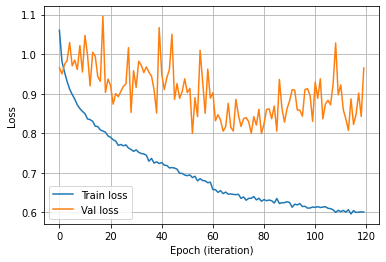

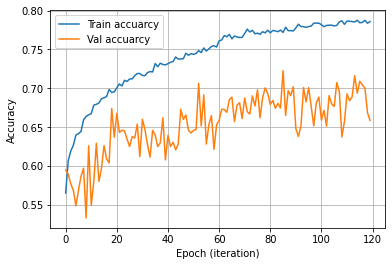

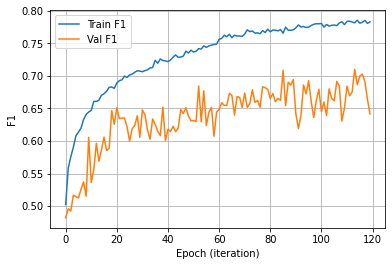

In [ ]:
model_FC.load_weights(model_name_fcn)
loss_FC = model_FC.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_FC)

plt.plot(history_FC.history['loss'], label = "Train loss")
plt.plot(history_FC.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_FC.history['accuracy'], label = "Train accuarcy")
plt.plot(history_FC.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_FC.history['f1'], label = "Train F1")
plt.plot(history_FC.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(510, 40, 7)
(189, 40, 7)
(56, 40, 7)


In [ ]:
model_FC = my_model_fully_connected(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks()
print(model_FC.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 7)]           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 280)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               143872    
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               1313

In [ ]:
history_FC = model_FC.fit(X_train, Y_train_oh, batch_size = 32, epochs = 200, verbose = 1, callbacks=[early_stop, monitor, lr_schedule], validation_data = (X_val, Y_val_oh))

Epoch 1/200
16/16 [==============================] - 4s 73ms/step - loss: 1.8690 - accuracy: 0.2952 - f1: 0.2641 - val_loss: 1.2895 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 1.3274 - accuracy: 0.3694 - f1: 0.3109 - val_loss: 1.2881 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 1.2963 - accuracy: 0.4309 - f1: 0.3265 - val_loss: 1.2875 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 1.2368 - accuracy: 0.4621 - f1: 0.2877 - val_loss: 1.2879 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 1.2255 - accuracy: 0.4237 - f1: 0.3282 - val_loss: 1.2888 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 6/200
16/16 [==============================] - 0s 17ms/step - loss: 1.1665 - accuracy: 0.5210 - f1: 0.3615 - val_l

Final loss (cross-entropy and accuracy and F1): [1.340956211090088, 0.2380952388048172, 0.0]


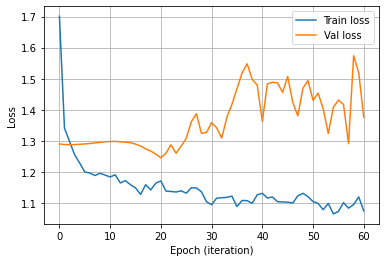

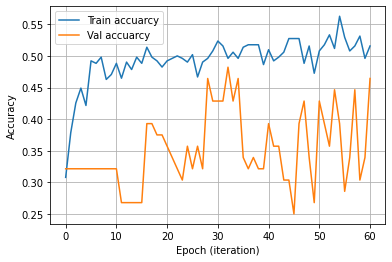

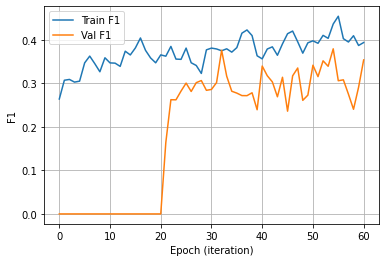

In [ ]:
model_FC.load_weights(model_name_fcn)
loss_FC = model_FC.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_FC)

plt.plot(history_FC.history['loss'], label = "Train loss")
plt.plot(history_FC.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_FC.history['accuracy'], label = "Train accuarcy")
plt.plot(history_FC.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_FC.history['f1'], label = "Train F1")
plt.plot(history_FC.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()